In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Subí tu archivo .db si aún no lo tenés en Colab
print("Por favor, subí el archivo 'Auditoria_KPMG.db':")
uploaded = files.upload()

# Conexión a la base de datos
conn = sqlite3.connect('Auditoria_KPMG.db')

# Carga de tablas a DataFrames de Pandas
df_asientos = pd.read_sql_query("SELECT * FROM Fact_Asientos", conn)
df_cuentas = pd.read_sql_query("SELECT * FROM Dim_Cuentas", conn)
df_prov = pd.read_sql_query("SELECT * FROM Dim_Proveedores", conn)

conn.close()

print("--- Datos cargados correctamente ---")
df_asientos.head()

Por favor, subí el archivo 'Auditoria_KPMG.db' que creamos en DBeaver:


Saving Auditoria_KPMG.db to Auditoria_KPMG.db
--- Datos cargados correctamente ---


,AsientoID,Fecha,CuentaID,ProveedorID,Debe,Haber,Nro_Factura,Usuario_Registro
0,5001,2025-07-23,102,4,12460.29,12460.29,F-9105,SISTEMA_AUTO
1,5002,2025-05-26,201,2,8709.06,8709.06,F-8951,SISTEMA_AUTO
2,5003,2025-12-16,503,1,1166.17,1166.17,F-8529,SISTEMA_AUTO
3,5004,2025-03-22,401,4,509.80,509.80,F-8009,SISTEMA_AUTO
4,5005,2025-12-19,102,3,2805.17,2805.17,F-5489,SISTEMA_AUTO


In [ ]:
# A. Detección de Asientos Desbalanceados (Error de Carga)
df_asientos['Diferencia'] = abs(df_asientos['Debe'] - df_asientos['Haber'])
errores_balance = df_asientos[df_asientos['Diferencia'] > 0.01].copy()

# B. Detección de Facturas Duplicadas (Riesgo de Pago Doble)
# Buscamos registros donde coinciden Proveedor, Nro de Factura y Monto
duplicados = df_asientos[df_asientos.duplicated(subset=['Nro_Factura', 'ProveedorID', 'Debe'], keep=False)].copy()

print(f"RESULTADOS DE LA AUDITORÍA:")
print(f"1. Asientos desbalanceados encontrados: {len(errores_balance)}")
print(f"2. Registros de facturas duplicadas encontrados: {len(duplicados)}")

# Mostrar los 5 casos más graves de duplicados
duplicados.sort_values(by='Debe', ascending=False).head()

RESULTADOS DE LA AUDITORÍA:
1. Asientos desbalanceados encontrados: 22
2. Registros de facturas duplicadas encontrados: 42


,AsientoID,Fecha,CuentaID,ProveedorID,Debe,Haber,Nro_Factura,Usuario_Registro,Diferencia
4897,9898,2025-07-17,501,4,14583.13,14583.13,F-6624,SISTEMA_AUTO,0.0
4896,9897,2025-07-17,501,4,14583.13,14583.13,F-6624,SISTEMA_AUTO,0.0
1002,6003,2025-05-30,101,2,14159.67,14159.67,F-5550,SISTEMA_AUTO,0.0
1003,6004,2025-05-30,101,2,14159.67,14159.67,F-5550,SISTEMA_AUTO,0.0
483,5484,2025-05-17,102,3,13616.95,13616.95,F-1060,SISTEMA_AUTO,0.0


/tmp/ipython-input-3005123700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_full, x='Tipo_Cuenta', y='Debe', estimator=sum, palette='viridis')
/tmp/ipython-input-3005123700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_prov.values, y=top_prov.index, palette='magma')


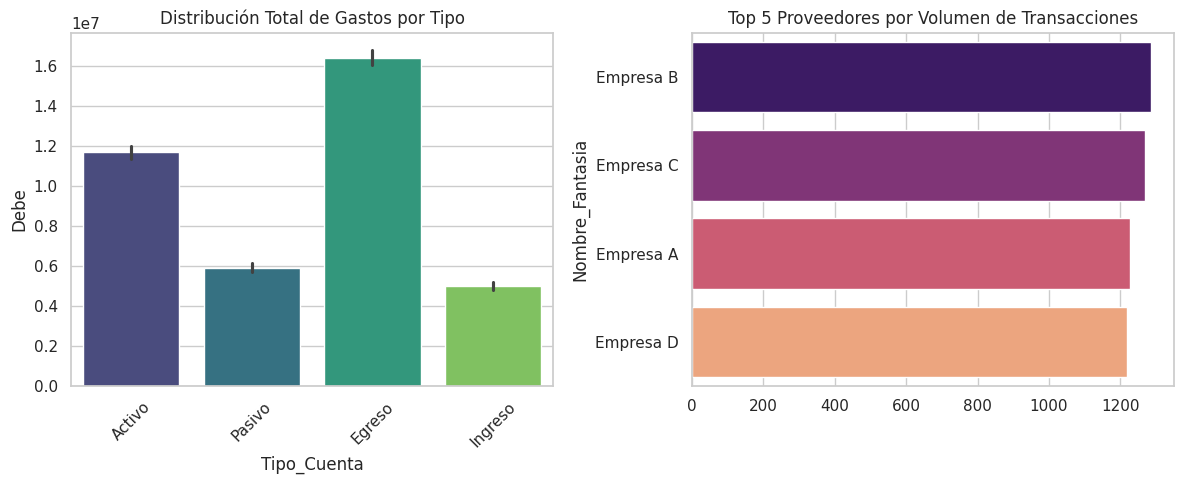

In [ ]:
# Configuración visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Gráfico 1: Gastos por Tipo de Cuenta
df_full = df_asientos.merge(df_cuentas, on='CuentaID')
plt.subplot(1, 2, 1)
sns.barplot(data=df_full, x='Tipo_Cuenta', y='Debe', estimator=sum, palette='viridis')
plt.title('Distribución Total de Gastos por Tipo')
plt.xticks(rotation=45)

# Gráfico 2: Top Proveedores con mayor cantidad de registros (Frecuencia)
plt.subplot(1, 2, 2)
df_prov_full = df_asientos.merge(df_prov, on='ProveedorID')
top_prov = df_prov_full['Nombre_Fantasia'].value_counts().head(5)
sns.barplot(x=top_prov.values, y=top_prov.index, palette='magma')
plt.title('Top 5 Proveedores por Volumen de Transacciones')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3673823132.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df_asientos.resample('M', on='Fecha')['Debe'].sum().reset_index()


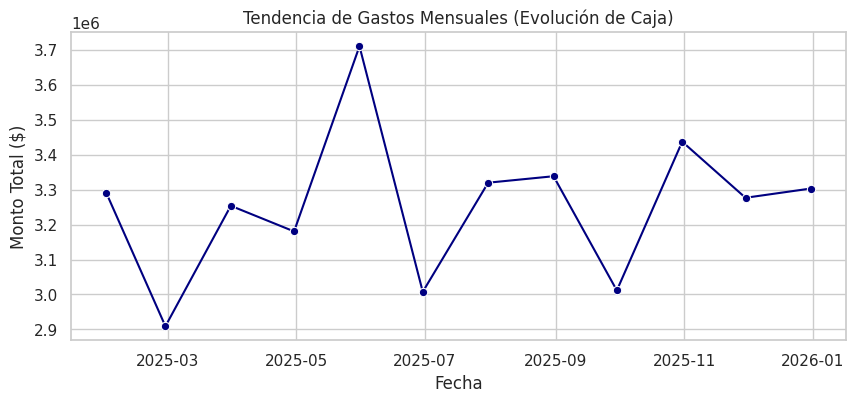

La variación promedio mensual es del 0.65%


In [ ]:
# 1. Preparar las fechas y agrupar por mes
df_asientos['Fecha'] = pd.to_datetime(df_asientos['Fecha'])
df_mensual = df_asientos.resample('M', on='Fecha')['Debe'].sum().reset_index()

# 2. Calcular la variación porcentual (Month-over-Month)
df_mensual['Variacion_pct'] = df_mensual['Debe'].pct_change() * 100

# 3. Visualización de la tendencia
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_mensual, x='Fecha', y='Debe', marker='o', color='navy')
plt.title('Tendencia de Gastos Mensuales (Evolución de Caja)')
plt.ylabel('Monto Total ($)')
plt.show()

print(f"La variación promedio mensual es del {df_mensual['Variacion_pct'].mean():.2f}%")

In [ ]:
# 1. Identificar facturas duplicadas (mismo proveedor, nro factura y monto)
duplicados_reales = df_asientos[df_asientos.duplicated(subset=['Nro_Factura', 'ProveedorID', 'Debe'], keep='first')]

# 2. Calcular el ahorro
monto_ahorro = duplicados_reales['Debe'].sum()

print("="*40)
print("INFORME DE IMPACTO ECONÓMICO")
print("="*40)
print(f"Facturas duplicadas detectadas: {len(duplicados_reales)}")
print(f"Ahorro potencial identificado: ${monto_ahorro:,.2f}")
print("="*40)

INFORME DE IMPACTO ECONÓMICO
Facturas duplicadas detectadas: 21
Ahorro potencial identificado: $152,608.58
